# Bidirectional inputs

In [1]:
import numpy as np
import tensorflow as tf
import helpers

tf.reset_default_graph()
sess = tf.InteractiveSession()
tf.__version__

'1.0.0'

In [2]:
PAD = 0
EOS = 1
UNK = 2

#change this to 10 for the original example to work
vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units * 2

In [3]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
encoder_inputs_length = tf.placeholder(shape=(None,), dtype=tf.int32, name='encoder_inputs_length')

encoder_inputs2 = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
encoder_inputs_length2 = tf.placeholder(shape=(None,), dtype=tf.int32, name='encoder_inputs_length')

decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')
# decoder_lengths = tf.placeholder(shape=(None,), dtype=tf.int32, name='decoder_lengths')

In [4]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
encoder_inputs_embedded2 = tf.nn.embedding_lookup(embeddings, encoder_inputs2)

In [5]:
from tensorflow.contrib.rnn import LSTMCell, LSTMStateTuple
encoder_cell = LSTMCell(encoder_hidden_units)

In [6]:
with tf.variable_scope('first'):
    ((encoder_fw_outputs,
      encoder_bw_outputs),
     (encoder_fw_final_state,
      encoder_bw_final_state)) = (
        tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell,
                                        cell_bw=encoder_cell,
                                        inputs=encoder_inputs_embedded,
                                        sequence_length=encoder_inputs_length,
                                        dtype=tf.float32, time_major=True)
        )
with tf.variable_scope('second'):
    ((encoder_fw_outputs2,
      encoder_bw_outputs2),
     (encoder_fw_final_state2,
      encoder_bw_final_state2)) = (
        tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell,
                                        cell_bw=encoder_cell,
                                        inputs=encoder_inputs_embedded2,
                                        sequence_length=encoder_inputs_length2,
                                        dtype=tf.float32, time_major=True)
        )

In [7]:
encoder_fw_outputs

<tf.Tensor 'first/bidirectional_rnn/fw/fw/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 20) dtype=float32>

In [8]:
encoder_bw_outputs

<tf.Tensor 'first/ReverseSequence:0' shape=(?, ?, 20) dtype=float32>

In [9]:
encoder_fw_final_state

LSTMStateTuple(c=<tf.Tensor 'first/bidirectional_rnn/fw/fw/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'first/bidirectional_rnn/fw/fw/while/Exit_3:0' shape=(?, 20) dtype=float32>)

In [10]:
encoder_bw_final_state

LSTMStateTuple(c=<tf.Tensor 'first/bidirectional_rnn/bw/bw/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'first/bidirectional_rnn/bw/bw/while/Exit_3:0' shape=(?, 20) dtype=float32>)

In [11]:
encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2)

encoder_final_state_c = tf.concat(
    (encoder_fw_final_state.c, encoder_bw_final_state.c), 1)

encoder_final_state_h = tf.concat(
    (encoder_fw_final_state.h, encoder_bw_final_state.h), 1)

encoder_final_state = LSTMStateTuple(
    c=encoder_final_state_c,
    h=encoder_final_state_h
)

In [12]:
encoder_outputs2 = tf.concat((encoder_fw_outputs2, encoder_bw_outputs2), 2)

encoder_final_state_c2 = tf.concat(
    (encoder_fw_final_state2.c, encoder_bw_final_state2.c), 1)

encoder_final_state_h2 = tf.concat(
    (encoder_fw_final_state2.h, encoder_bw_final_state2.h), 1)

encoder_final_state2 = LSTMStateTuple(
    c=encoder_final_state_c2,
    h=encoder_final_state_h2
)

In [13]:
combined_state = LSTMStateTuple(
    c=tf.concat([encoder_final_state.c, encoder_final_state2.c], 1),
    h=tf.concat([encoder_final_state.h, encoder_final_state2.h], 1)
)

In [14]:
combined_state.c.get_shape().as_list()[1]

80

In [15]:
#A fully connected layer between encoder_final_state.c (encoder_hidden_units) and decoder_hidden_units
def multilayer_perceptron(x, w, b):
    layer_1 = tf.add(tf.matmul(x, w), b)
    return tf.nn.relu(layer_1)
    
with tf.variable_scope('c'):
    wc = tf.Variable(tf.random_normal([combined_state.c.get_shape().as_list()[1], decoder_hidden_units]))
    bc = tf.Variable(tf.random_normal([decoder_hidden_units]))
    
with tf.variable_scope('h'):
    wh = tf.Variable(tf.random_normal([combined_state.h.get_shape().as_list()[1], decoder_hidden_units]))
    bh = tf.Variable(tf.random_normal([decoder_hidden_units]))
projected_state = tf.contrib.rnn.LSTMStateTuple(
    c=multilayer_perceptron(combined_state.c, wc, bc),
    h=multilayer_perceptron(combined_state.h, wh, bh),
)

In [16]:
decoder_cell = LSTMCell(decoder_hidden_units)

In [17]:
encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))

In [18]:
decoder_lengths = tf.maximum(encoder_inputs_length, encoder_inputs_length2) + 3

In [19]:
W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size], -1, 1), dtype=tf.float32)
b = tf.Variable(tf.zeros([vocab_size]), dtype=tf.float32)

In [20]:
assert EOS == 1 and PAD == 0

eos_time_slice = tf.ones([batch_size], dtype=tf.int32, name='EOS')
pad_time_slice = tf.zeros([batch_size], dtype=tf.int32, name='PAD')

eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)

In [21]:
def loop_fn_initial():
    initial_elements_finished = (0 >= decoder_lengths)  # all False at the initial step
    initial_input = eos_step_embedded
    initial_cell_state = projected_state
    initial_cell_output = None
    initial_loop_state = None  # we don't need to pass any additional information
    return (initial_elements_finished,
            initial_input,
            initial_cell_state,
            initial_cell_output,
            initial_loop_state)

In [22]:
def loop_fn_transition(time, previous_output, previous_state, previous_loop_state):

    def get_next_input():
        output_logits = tf.add(tf.matmul(previous_output, W), b)
        prediction = tf.argmax(output_logits, axis=1)
        next_input = tf.nn.embedding_lookup(embeddings, prediction)
        return next_input
    
    elements_finished = (time >= decoder_lengths) # this operation produces boolean tensor of [batch_size]
                                                  # defining if corresponding sequence has ended

    finished = tf.reduce_all(elements_finished) # -> boolean scalar
    input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
    state = previous_state
    output = previous_output
    loop_state = None

    return (elements_finished, 
            input,
            state,
            output,
            loop_state)

In [23]:
def loop_fn(time, previous_output, previous_state, previous_loop_state):
    if previous_state is None:    # time == 0
        assert previous_output is None and previous_state is None
        return loop_fn_initial()
    else:
        return loop_fn_transition(time, previous_output, previous_state, previous_loop_state)

decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

In [24]:
decoder_outputs

<tf.Tensor 'TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 40) dtype=float32>

In [25]:
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size))

In [26]:
decoder_prediction = tf.argmax(decoder_logits, 2)

In [27]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [28]:
sess.run(tf.global_variables_initializer())

In [29]:
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[3, 3, 6, 9, 2]
[8, 3, 7, 3]
[3, 4, 7, 8, 9]
[8, 7, 6, 4, 9, 5]
[8, 8, 5, 5]
[2, 3, 2, 9]
[3, 8, 5, 9, 8]
[4, 2, 6, 8]
[7, 6, 5]
[2, 2, 2, 9, 3]


In [30]:
def add(batch1, batch2):
    targetSeq = []
    for i in range(0, max(len(batch1), len(batch2))):
        if i >=len(batch1):
            targetSeq.append((int)(batch2[i]/2))
        elif i >=len(batch2):
            targetSeq.append((int)(batch1[i])/2)
        else:
            targetSeq.append((int)((batch1[i]+batch2[i])/2))
    return targetSeq
def next_feed():
    batch1 = next(batches)
    batch2 = next(batches)
    encoder_inputs_1, encoder_input_lengths_1 = helpers.batch(batch1)
    encoder_inputs_2, encoder_input_lengths_2 = helpers.batch(batch2)
    
    decoder_targets_, _ = helpers.batch(
    [add(x,y)  + [EOS] + [PAD] * 2 for x,y in zip(batch1, batch2)]
    )
    return {
        encoder_inputs: encoder_inputs_1,
        encoder_inputs_length: encoder_input_lengths_1,
        encoder_inputs2: encoder_inputs_2,
        encoder_inputs_length2: encoder_input_lengths_2,
        decoder_targets: decoder_targets_,
    }

In [31]:
loss_track = []
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp1, inp2, pred) in enumerate(zip(fd[encoder_inputs].T, fd[encoder_inputs2].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp1))
                print('    input     > {}'.format(inp2))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.5091679096221924
  sample 1:
    input     > [5 4 9 3 4 8 8 0]
    input     > [4 3 7 9 0 0 0 0]
    predicted > [4 4 4 4 2 4 4 2 4 2 0]
  sample 2:
    input     > [4 8 7 4 0 0 0 0]
    input     > [5 9 7 3 6 0 0 0]
    predicted > [4 4 4 4 2 4 4 2 0 0 0]
  sample 3:
    input     > [3 4 9 9 3 7 4 0]
    input     > [9 9 9 5 8 6 7 6]
    predicted > [4 4 4 4 4 2 2 4 4 2 4]

batch 1000
  minibatch loss: 0.9064642786979675
  sample 1:
    input     > [5 3 4 3 4 6 0 0]
    input     > [3 2 4 4 0 0 0 0]
    predicted > [4 3 3 3 3 3 1 0 0 0 0]
  sample 2:
    input     > [8 4 7 7 0 0 0 0]
    input     > [5 5 2 0 0 0 0 0]
    predicted > [6 5 4 3 1 0 0 0 0 0 0]
  sample 3:
    input     > [3 3 3 8 2 0 0 0]
    input     > [6 7 3 9 0 0 0 0]
    predicted > [4 4 5 4 1 1 0 0 0 0 0]

batch 2000
  minibatch loss: 0.6291081309318542
  sample 1:
    input     > [2 5 3 0 0 0 0 0]
    input     > [9 2 9 9 2 0 0 0]
    predicted > [5 4 4 4 1 1 0 0 0 0 0]
  sample 2:
    i

loss 0.4518 after 300100 examples (batch_size=100)


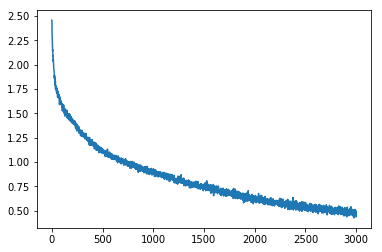

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))

# Convert above stuff for sentences

In [32]:
import data, random, numpy as np
train,test = data.readfnp()
max_batches = 30001
ran = np.random.randint(1, high=4, size=max_batches)
idx = []
for batch in range(max_batches):
    idx.append(np.random.choice(len(train[ran[batch]]),size=100, replace=False))

In [40]:
#save this stuff 
import pickle
pickle.dump( (ran, idx), open( "randomstuff", "wb" ) )

In [41]:
def next_feed2(i):
    samples = data.getnextr(100, train, ran[i], idx[i])
    batch1 = [x for x,y,z in samples]
    batch2 = [y for x,y,z in samples]
    encoder_inputs_1, encoder_input_lengths_1 = helpers.batch(batch1)
    encoder_inputs_2, encoder_input_lengths_2 = helpers.batch(batch2)
    
    max_len = max(encoder_inputs_1.shape[0], encoder_inputs_2.shape[0])
    encoder_inputs_1_r = np.zeros((max_len, 100), dtype=np.int32)
    encoder_inputs_1_r[:encoder_inputs_1.shape[0], :encoder_inputs_1.shape[1]] = encoder_inputs_1
    
    encoder_inputs_2_r = np.zeros((max_len, 100), dtype=np.int32)
    encoder_inputs_2_r[:encoder_inputs_2.shape[0], :encoder_inputs_2.shape[1]] = encoder_inputs_2
    
    decoder_targets_, oo = helpers.batch(
    [z  + [EOS] + [PAD] * 2 for x,y,z in samples]
    )
    return {
        encoder_inputs: encoder_inputs_1_r,
        encoder_inputs_length: encoder_input_lengths_1,
        encoder_inputs2: encoder_inputs_2_r,
        encoder_inputs_length2: encoder_input_lengths_2,
        decoder_targets: decoder_targets_,
        decoder_lengths: oo
    }

In [42]:
import data
loss_track = []

batches_in_epoch = 1000
v, iv = data.vocab()
iv[0]='PAD'
iv[1]='EOS'
iv[2]='UNK'

try:
    for batch in range(max_batches):
        fd = next_feed2(batch)
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)
        if(batch%30==0):
            print(batch)
        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp1, inp2, pred) in enumerate(zip(fd[encoder_inputs].T, fd[encoder_inputs2].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format([iv[x] for x in inp1]))
                print('    input     > {}'.format([iv[x] for x in inp2]))
                print('    predicted > {}'.format([iv[x] for x in pred]))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

0
batch 0
  minibatch loss: 10.728058815002441
  sample 1:
    input     > ['``', 'i', 'scratch', 'your', 'back', ',', 'you', 'scratch', 'mine', "''", 'is', 'what', 'he', 'said', '.', 'PAD', 'PAD', 'PAD', 'PAD']
    input     > ['i', "'m", 'not', 'taking', 'care', 'of', 'merlot', ',', 'that', 'would', 'involve', 'me', 'seeing', 'him', 'more', 'than', 'once', '.', 'PAD']
    predicted > ['psychic', 'twigs', 'twang', 'twigs', 'ytmnd', 'airing', 'shion', 'airing', 'katie', 'bobcat', 'powering', 'sudanese', 'sudanese', 'krystal', 'hoboken', 'avocados', 'gale']
  sample 2:
    input     > ['quatre', 'asked', 'with', 'a', 'smile', 'on', 'his', 'face', '.', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
    input     > ['yzak', 'nodded', 'lightly', ',', 'watching', 'the', 'cup', 'of', 'tea', 'he', 'still', 'touched', 'with', 'his', 'fingertips', '.', 'PAD', 'PAD', 'PAD']
    predicted > ['rearview', 'rearview', 'puzzles', 'puzzles', 'puzzles', 'insurmountable', '/i', 'f

loss 5.5017 after Tensor("mul:0", shape=(), dtype=int32) examples (batch_size=Tensor("unstack:1", shape=(), dtype=int32))


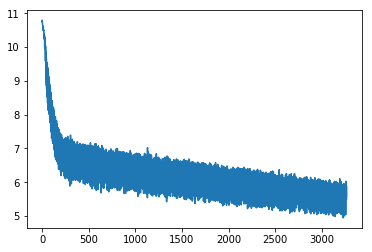

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))

# Beam Search

In [52]:
from tf_beam_decoder import beam_decoder
decoded_sparse, decoded_logprobs = beam_decoder(
    cell=decoder_cell,
    beam_size=7,
    stop_token=PAD,
    initial_state=projected_state.c,
    initial_input=EOS,
    tokens_to_inputs_fn=lambda tokens: tf.nn.embedding_lookup(embeddings, tokens),
)
# isinstance(projected_state.c, tf.Tensor)

ValueError: State should be a sequence or tensor

In [39]:
beam_size=5

def loop_fn_initial():
    initial_elements_finished = (0 >= decoder_lengths)  # all False at the initial step
    initial_input = eos_step_embedded
    initial_cell_state = encoder_final_state
    initial_cell_output = None
    initial_loop_state = None  # we don't need to pass any additional information
    return (initial_elements_finished,
            initial_input,
            initial_cell_state,
            initial_cell_output,
            initial_loop_state)
def loop_fn_transition(time, previous_output, previous_state, previous_loop_state, k):
    
    def get_next_input():
        output_logits = tf.add(tf.matmul(previous_output, W), b)
        prediction = tf.argmax(output_logits, axis=1)
        
        best_probs, indices = tf.nn.top_k(logits, beam_size)
        prediction = indices[-1]#TODO
        
        assert tf.argmax(output_logits, axis=1) == indices[0]
        
        next_input = tf.nn.embedding_lookup(embeddings, prediction)
        return next_input
    
    elements_finished = (time >= decoder_lengths) # this operation produces boolean tensor of [batch_size]
                                                  # defining if corresponding sequence has ended

    finished = tf.reduce_all(elements_finished) # -> boolean scalar
    input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
    state = previous_state
    output = previous_output
    loop_state = None

    return (elements_finished, 
            input,
            state,
            output,
            loop_state)
def loop_fn(time, previous_output, previous_state, previous_loop_state, k):
    if previous_state is None:    # time == 0
        assert previous_output is None and previous_state is None
        return loop_fn_initial()
    else:
        return loop_fn_transition(time, previous_output, previous_state, previous_loop_state, k)

def custom_rnn(cell,
    loop_fn,
    parallel_iterations=None,
    swap_memory=False,
    scope=None):
    
    time = tf.constant(0, dtype=tf.int32)
    (finished, next_input, initial_state, _, loop_state) = loop_fn(
        time=time, previous_output=None, previous_state=None, previous_loop_state=None, k=0)
    emit_ta = tf.TensorArray(dynamic_size=True, dtype=initial_state.dtype)
    state = initial_state
    while not all(finished):
        (output, cell_state) = cell(next_input, state)
        
        
        (next_finished, next_input, next_state, emit, loop_state) = loop_fn(
            time=time + 1, previous_output=output, previous_state=cell_state,
            previous_loop_state=loop_state, k=0)
        
        # Emit zeros and copy forward state for minibatch entries that are finished.
        state = tf.where(finished, state, next_state)
        emit = tf.where(finished, tf.zeros_like(emit), emit)
        emit_ta = emit_ta.write(time, emit)
        # If any new minibatch entries are marked as finished, mark these.
        finished = tf.logical_or(finished, next_finished)
        time += 1
    return (emit_ta, state, loop_state)
    
decoder_outputs_ta, decoder_final_state, _ = custom_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

    
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size))
decoder_prediction = tf.argmax(decoder_logits, 2)

stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

sess.run(tf.global_variables_initializer())
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)
def add(batch1, batch2):
    targetSeq = []
    for i in range(0, max(len(batch1), len(batch2))):
        if i >=len(batch1):
            targetSeq.append((int)(batch2[i]/2))
        elif i >=len(batch2):
            targetSeq.append((int)(batch1[i])/2)
        else:
            targetSeq.append((int)((batch1[i]+batch2[i])/2))
    return targetSeq
def next_feed():
    batch1 = next(batches)
    batch2 = next(batches)
    encoder_inputs_1, encoder_input_lengths_1 = helpers.batch(batch1)
    encoder_inputs_2, encoder_input_lengths_2 = helpers.batch(batch2)
    
    decoder_targets_, _ = helpers.batch(
    [add(x,y)  + [EOS] + [PAD] * 2 for x,y in zip(batch1, batch2)]
    )
    return {
        encoder_inputs: encoder_inputs_1,
        encoder_inputs_length: encoder_input_lengths_1,
        encoder_inputs2: encoder_inputs_2,
        encoder_inputs_length2: encoder_input_lengths_2,
        decoder_targets: decoder_targets_,
    }
loss_track = []
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp1, inp2, pred) in enumerate(zip(fd[encoder_inputs].T, fd[encoder_inputs2].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp1))
                print('    input     > {}'.format(inp2))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

ValueError: Size must be provided if handle is not provided